## INLÄMNING DEL 2

# Bearbeta data
- Läser in data från csv-fil
- Kontrollerar dataset
- Konverterar nödvändiga datatyper till rätt typ

In [1]:
import sys
sys.executable

'f:\\OneDrive\\DOKUMENT\\VICTORIA\\Data_Scientist\\Inlamningsuppg\\Health_study\\.venv\\Scripts\\python.exe'

In [2]:
import pandas as pd
import numpy as np
from data_cleaner import load_data, DataCleaner
from visualization import summary_table, plot_hist, plot_all_num_distributions, plot_group_box, plot_proportion_bar
import matplotlib.pyplot as plt


# 1. Ladda & rensa
df_raw = load_data("data/health_study_dataset.csv")
df = DataCleaner(df_raw).process()



sex: clean
smoker: clean
Kolumnen 'disease' innehåller endast 0 och 1 - konverterad till bool.
Alla ID i 'id' är unika – inga dubbletter hittades.

column      dtype        unique values
--------------------------------------------------------------------------------
id           int64        800 uniques, min=1, max=800
age          int64        70 uniques, min=18, max=90
sex          category     ['F', 'M']
height       float64      351 uniques, min=144.4, max=200.4
weight       float64      424 uniques, min=33.7, max=114.4
systolic_bp  float64      385 uniques, min=106.8, max=185.9
cholesterol  float64      303 uniques, min=2.5, max=7.88
smoker       category     ['No', 'Yes']
disease      bool         [False, True]
--------------------------------------------------------------------------------


### Datakontroll och förbehandling

En kvalitetskontroll genomfördes av datasetet.  
- Kolumnerna `sex` och `smoker` har kontrollerats och konverterats till kategoriska variabler.
- Kolumnen `disease` bestod endast av värdena 0 och 1 och konverterades därför till en boolesk variabel.  
- Kontroll av `id` visade att samtliga observationer är unika, vilket innebär att inga dubbletter förekommer.  

Datasetet är därmed välstrukturerat och lämpligt för vidare analys.

# Beskrivande analys

,mean,median,std,min,max
age,49.426250,50.00,14.501118,18.0,90.00
height,171.849250,171.35,9.804259,144.4,200.40
weight,73.413000,73.20,13.685059,33.7,114.40
systolic_bp,149.178625,149.40,12.793360,106.8,185.90
cholesterol,4.929150,4.97,0.848413,2.5,7.88


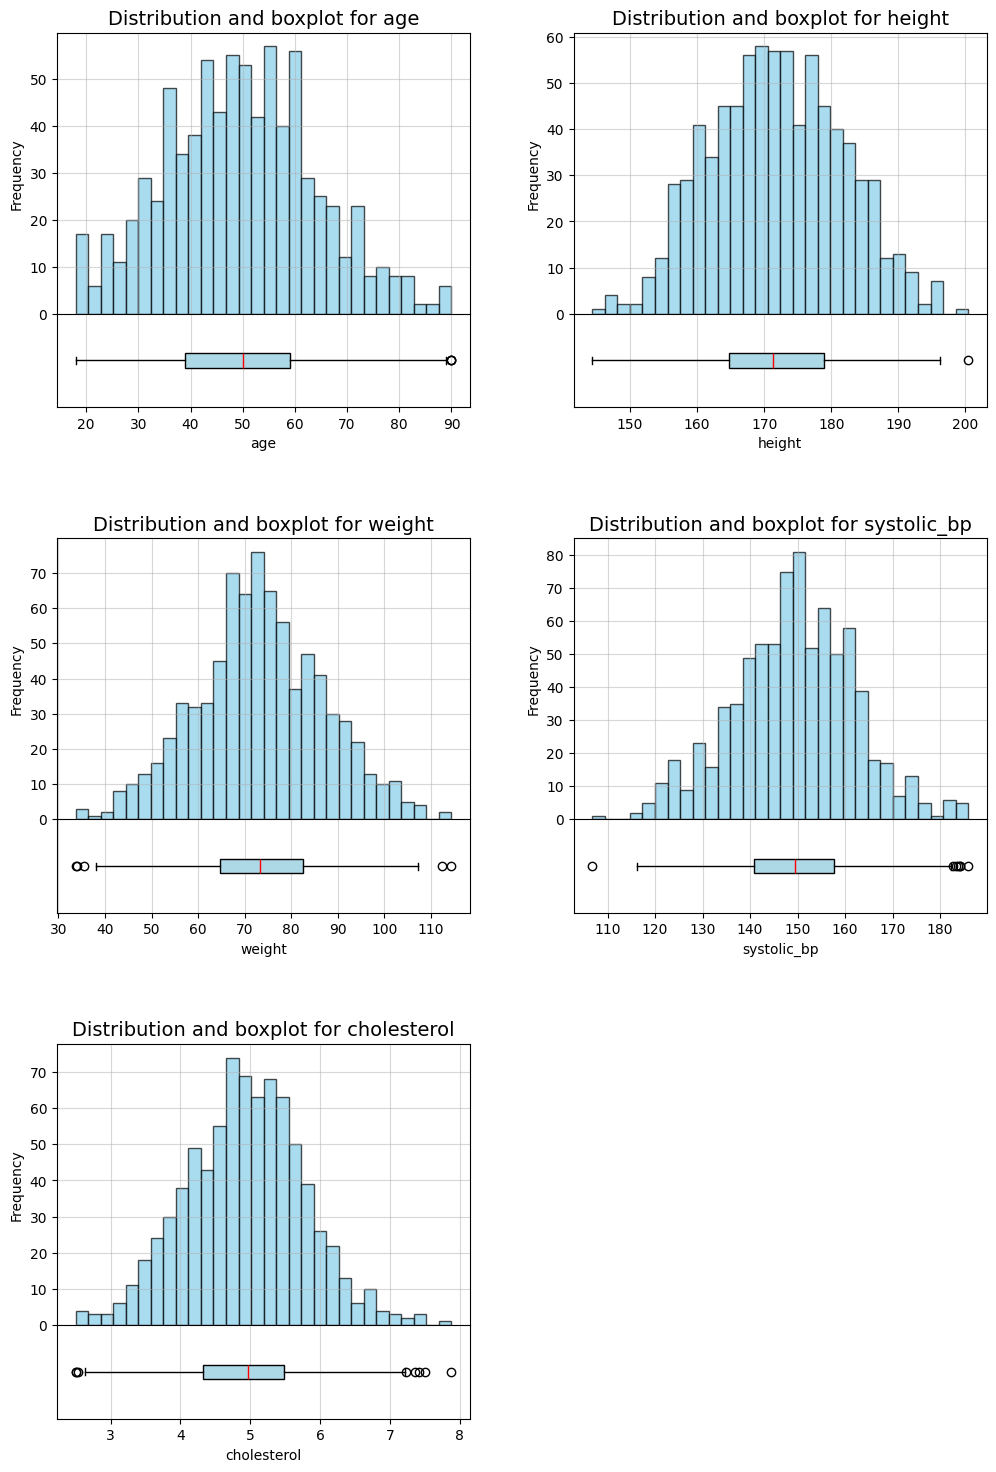

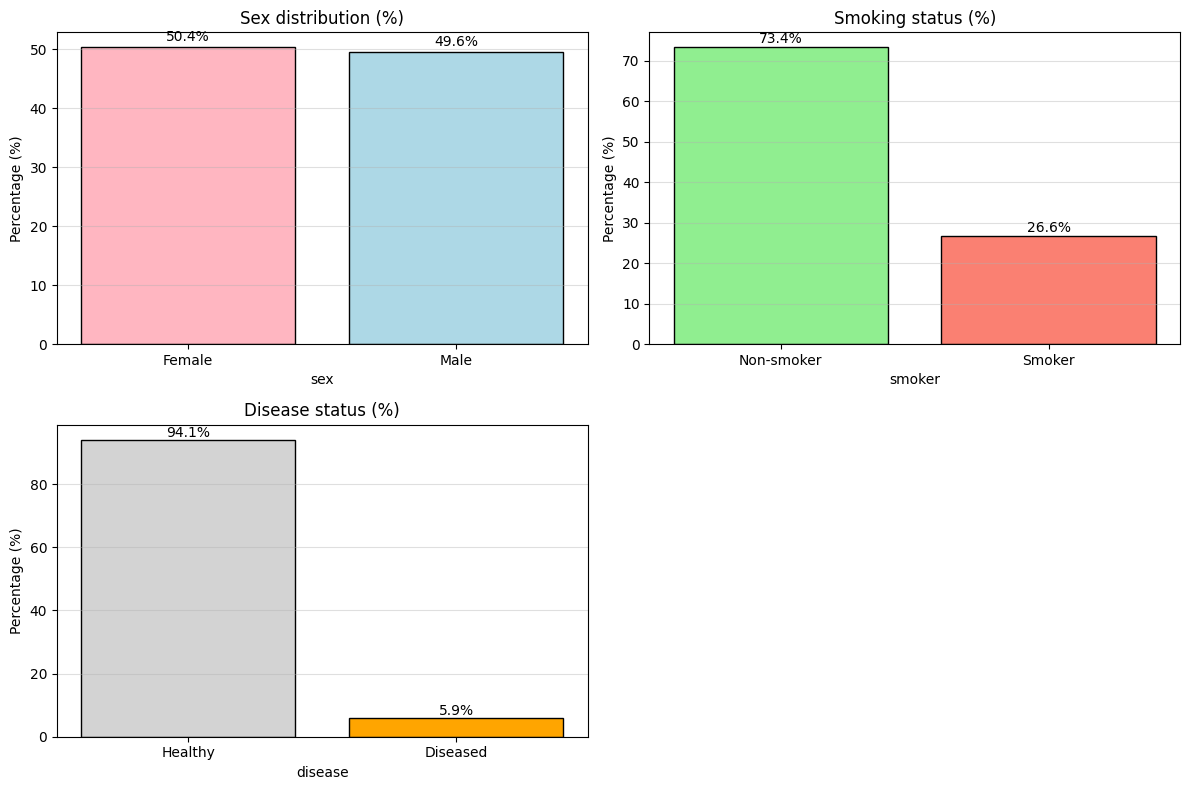

In [3]:
from visualization import summary_table, plot_hist, plot_all_num_distributions, plot_group_box, plot_proportion_bar, plot_all_categorical_bars
import matplotlib.pyplot as plt

# 2. Sammanfattningstabell
summary = summary_table(df)
display(summary)

# 3. Alla numeriska distributioner
plot_all_num_distributions(df)

# 4. Alla kategoriska fördelningar
plot_all_categorical_bars(df)


## Tolkning av data

Den inledande analysen visar att datasetet överlag innehåller rimliga och realistiska värden, där variablerna uppvisar ungefär **normalfördelade** mönster. Det förekommer vissa extremvärden, särskilt i vikt, blodtryck och kolesterol, men dessa ligger inom tänkbara medicinska intervall och bedöms inte vara resultat av felregistrering. Därför behålls samtliga observationer inför vidare analys.

Utöver detta uppvisar de kategoriska variablerna en tydlig **obalans i gruppstorlekar**, särskilt för rökstatus och sjukdom. Andelen rökare är relativt liten och endast en mindre del av deltagarna är sjuka. Detta kan minska den statistiska styrkan vid gruppjämförelser, och resultaten bör därför tolkas med viss försiktighet, framför allt för den sjukdomsdrabbade gruppen.

Utöver detta visar de kategoriska variablerna en **ojämn gruppfördelning**, framför allt avseende rökstatus och sjukdomsförekomst. Andelen rökare är betydligt lägre än andelen icke-rökare, och endast en liten del av deltagarna är klassificerade som sjuka. Denna obalans innebär att vissa grupper har få observationer, vilket kan påverka den statistiska styrkan och göra jämförelser mellan grupper mer känsliga för slumpvariation. Vid senare analyser bör därför gruppstorlekar tas i beaktande, särskilt när man tolkar resultat för den sjukdomsdrabbade gruppen.

# Simulering kopplad till caset

In [4]:
from confidence_intervals import ci_prop_normal

# andel i verklig data
real_prop = (df["disease"] == True).mean()
n_data = len(df)

# CI för verklig andel
level = 0.95
ci_low, ci_high, sd, z = ci_prop_normal(real_prop, n_data, level=level)

# Simulering
rng = np.random.default_rng(42)
n_sim=1000
simulated = rng.random(n_sim) < real_prop #Create a list with True and False values similar to real_prop
#simulated = np.random.choice([True, False], size=1000, p=[real_prop, 1-real_prop]) # same but slower
sim_prop = simulated.mean()

print(f"Andel i data: {real_prop*100:.2f}%")
print(f"Andel i simulering: {sim_prop*100:.2f}%")
print(f"{int(level*100)}% CI (normalapprox) för verklig andel: [{ci_low*100:.2f}%, {ci_high*100:.2f}%]")
#print(f"z = {z:.3f}, SD = {sd*100:.2f}%")
print("Ligger simulerad andel inom bandet?",
      "Ja" if ci_low <= sim_prop <= ci_high else "Nej")

Andel i data: 5.88%
Andel i simulering: 6.50%
95% CI (normalapprox) för verklig andel: [4.25%, 7.50%]
Ligger simulerad andel inom bandet? Ja


### Tolkning av simulering:
 
Den simulerade andelen (6,30 %) ligger inom det 95-procentiga konfidensintervall som man kan förvänta sig kring den verkliga andelen (5,88 %). Eftersom simuleringen bygger på ett stort antal personer (1000 stycken) och sjukdomsförekomsten är låg, är det naturligt att andelen varierar något. Skillnaden är därför helt rimlig och beror på slumpen – simuleringen matchar datan väl.

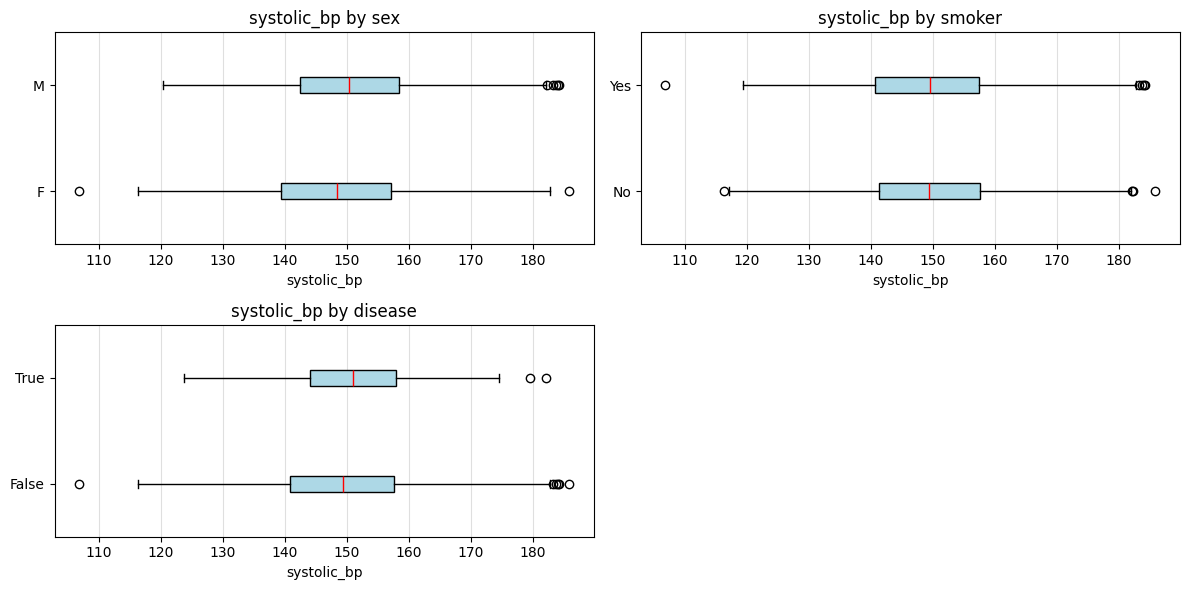


Systolic BP sammanfattning per sex:


,n,mean,median,std,min,max,ci_lower,ci_upper
sex,,,,,,,,
F,403,148.1,148.4,13.2,106.8,185.9,146.8,149.4
M,397,150.2,150.3,12.3,120.4,184.2,149.0,151.5


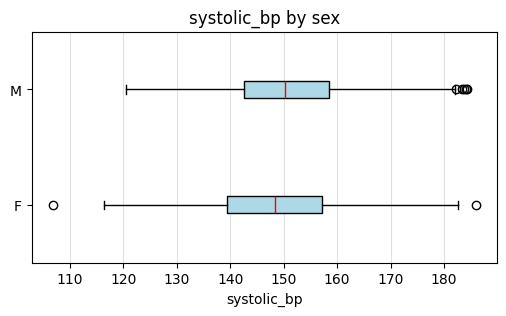


Systolic BP sammanfattning per smoker:


,n,mean,median,std,min,max,ci_lower,ci_upper
smoker,,,,,,,,
No,587,149.1,149.3,12.6,116.3,185.9,148.0,150.1
Yes,213,149.5,149.5,13.3,106.8,184.2,147.7,151.3


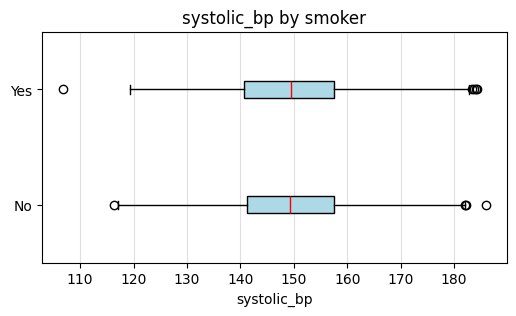


Systolic BP sammanfattning per disease:


,n,mean,median,std,min,max,ci_lower,ci_upper
disease,,,,,,,,
False,753,149.1,149.3,12.8,106.8,185.9,148.2,150.0
True,47,150.8,151.0,13.2,123.7,182.1,147.0,154.5


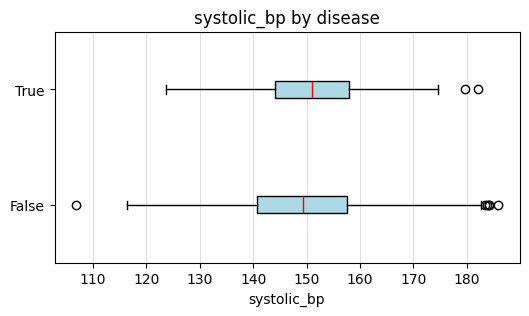

In [5]:
from health_analyzer import HealthAnalyzer

# 2. Skapa analyzer-objekt
analyzer = HealthAnalyzer(df, bp_col="systolic_bp")

fig, axes = analyzer.plot_bp_multi_boxgrid(
    group_cols=["sex", "smoker", "disease"]   # valfritt
)
plt.show()

# for col in ["sex", "smoker", "disease"]:
#     print(f"\nSummary for systolic_bp grouped by {col}:")
#     display(analyzer.bp_summary_by_group(col))


# Kön
summary_sex = analyzer.analyze_bp_by_group("sex", order=["F", "M"])

# Rökare
summary_smoker = analyzer.analyze_bp_by_group("smoker", order=["No", "Yes"])

# Sjukdom
summary_disease = analyzer.analyze_bp_by_group("disease", order=[False, True])





In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm, ttest_ind, t as t_dist
import io
from contextlib import redirect_stdout
#import seaborn as sns

pd.options.display.float_format = "{:.2f}".format

# Välj Seaborn-tema
#sns.set_theme(style="whitegrid")


# Systoliskt blodtryck

Vidare analyser görs för Systoliskt blodtryck då det kan antas vara utfallsvariabel, alltså andra värden kan antas vara en förklarande variabel för det systoliksa blodtrycket.

## Konfidensintervall

In [7]:
from confidence_intervals import ci_methods_table #ci_norm, ci_mean_boot_perc, ci_mean_boot_bca,

# CI för systoliskt blodtryck med tre metoder

ci_df = ci_methods_table(df["systolic_bp"], confidence=0.95, n_boot=10_000, random_state=42)
display(ci_df.style.format({"Medel": "{:.2f}", "KI nedre": "{:.2f}", "KI övre": "{:.2f}"}))




,Metod,Medel,KI nedre,KI övre,Nivå (%)
0,Normalapproximation,149.18,148.29,150.07,95
1,Bootstrap (percentil),149.18,148.31,150.05,95
2,Bootstrap (BCa),149.18,148.30,150.03,95


### Tolkning av skattning av konfidensintervall
Resultaten från de tre metoderna visar liknande 95 %-konfidensintervall för medelvärdet av systoliskt blodtryck, vilket tyder på en stabil skattning som inte är känslig för metodval.

Normalapproximationen fungerar väl då urvalet är stort och blodtrycket är ungefär normalfördelat (se figur "Distribution of systolic blood pressure" ).

Bootstrapmetoderna ger en icke-parametrisk kontroll, där BCa justerar för eventuell skevhet. De överlappande intervallen antyder att skillnaderna främst beror på slumpvariation.

## Test hur bra CI-metoderna för konfidensintervall är

Med hjälp av simulering undersöks om olika konfidensintervallmetoder verkligen når sin avsedda täckningsgrad och hur breda intervallen blir. Det ger en praktisk kontroll av metodernas noggrannhet.

In [8]:
from ci_simulation import evaluate_ci_methods

res = evaluate_ci_methods(df["systolic_bp"],
                            n=50, trials=100, confidence=0.95, n_boot=20_000, random_state=42)

res_sv = (
    res.reset_index()
       .rename(columns={
           "method": "Metod",
           "coverage": "Täckningsgrad",
           "avg_width": "Genomsnittlig bredd",
           "std_width": "SD för bredd"
       })
       .round(3)
)

display(
    res_sv.style.format({
        "Täckningsgrad": "{:.2f}",
        "Genomsnittlig bredd": "{:.3f}",
        "SD för bredd": "{:.3f}"
    }).set_caption("Jämförelse av konfidensintervall-metoder för systoliskt blodtryck"))


,Metod,Täckningsgrad,Genomsnittlig bredd,SD för bredd
0,normal,0.97,7.076,0.727
1,bootstrap,0.97,7.018,0.718
2,bca,0.95,7.027,0.719


### Tolkning av test av olika metoder för skattning av konfidensintervall

Resultaten visar att alla tre metoder – normalapproximation, bootstrap (percentil) och bootstrap BCa – fungerar väl för att skatta 95 % konfidensintervall för medelvärdet av systoliskt blodtryck.

-   **Täckningsgraden** ligger på 0,95–0,97, vilket ligger mycket nära den teoretiska nivån 0,95.

-   **Intervallbredderna** är nästan identiska (≈ 7,0), med mycket liten variation mellan metoderna.

-   **Bootstrap-metoderna**, särskilt BCa, brukar ge fördelar vid skeva fördelningar eller små stickprov, men här syns ingen tydlig skillnad eftersom blodtrycket är ungefär symmetriskt och stickproven (n=50) är tillräckligt stora för att normalapproximationen ska fungera bra.


## Hypotesprövning

Hypotes: Rökare har högre medel-blodtryck än icke-rökare

H₀: mean(Yes) − mean(No) = 0

H₁: mean(Yes) − mean(No) > 0 (rökare har högre medelblodtryck)

## Tillämpning och visualisering av hypotesprövning

Antal rökare: 213
Antal icke-rökare: 587


,Metod,Observerad skillnad,p-värde,KI nedre,KI övre
0,Bootstrap,0.472,0.496,-1.558,2.523
1,Welch t-test,0.472,0.326,-1.256,2.200


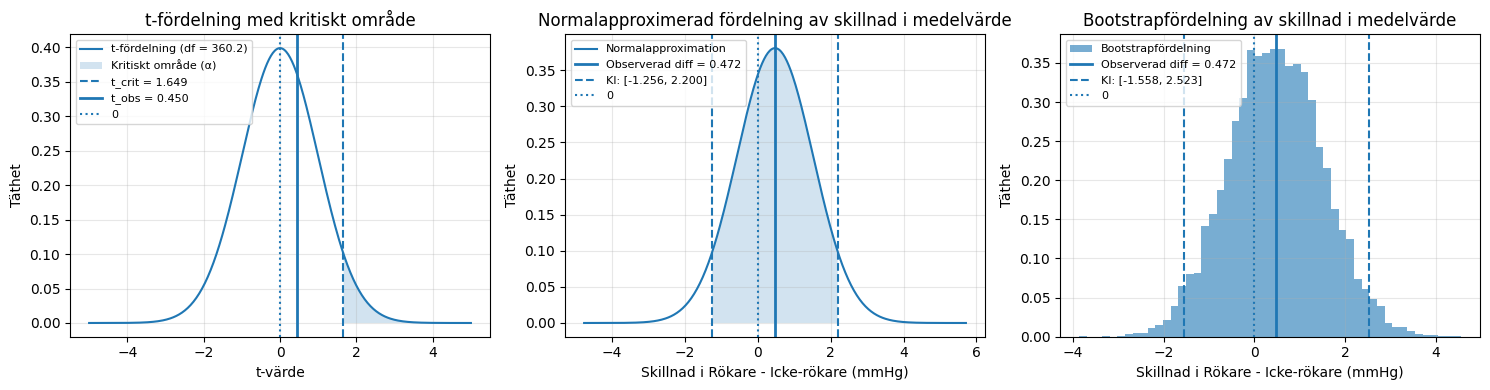

In [9]:
from hypothesis_analyzer import MeanDiffAnalyzer

smoker_yes = df.loc[df["smoker"] == "Yes", "systolic_bp"]
smoker_no  = df.loc[df["smoker"] == "No",  "systolic_bp"]

print(f"Antal rökare: {len(smoker_yes)}")
print(f"Antal icke-rökare: {len(smoker_no)}")

analyzer = MeanDiffAnalyzer(
    smoker_yes,
    smoker_no,
    name1="Rökare",
    name2="Icke-rökare",
    confidence=0.95,
    two_sided=False,
    n_boot=10_000,
)

# Resultattabell
res_df = analyzer.summary_table()
display(
    res_df.style
        .format({
            "Observerad skillnad": "{:.3f}",
            "p-värde": "{:.3f}",
            "KI nedre": "{:.3f}",
            "KI övre": "{:.3f}",
        })
        .set_caption(
            "Jämförelse mellan bootstrap och Welch’s t-test\n(systoliskt blodtryck, rökare vs icke-rökare)"
        )
)

# Stor figur med tre paneler
fig, axes = analyzer.plot_overview()

### Tolkning

Både bootstrapmetoden och Welch’s t-test ger mycket liknande resultat för skillnaden i medelvärde av systoliskt blodtryck mellan rökare och icke-rökare.
Den observerade skillnaden är liten (≈ 0,47 mmHg), och båda metoderna ger konfidensintervall som inkluderar noll. Detta innebär att ingen statistiskt säkerställd skillnad påvisas vid 95 % konfidensnivå.

De tre graferna visar fördelningar som är centrerade nära noll, vilket stämmer överens med att den observerade skillnaden är liten. Symmetrin i t- och normalfördelningen följer av antagandena i metoderna, medan bootstrapfördelningen visar att resultaten är stabila även utan sådana antaganden.

P-värdena (0,50 för bootstrap och 0,33 för Welch’s t-test) ligger långt över den vedertagna signifikansgränsen på 0,05. Nollhypotesen kan därför inte förkastas, vilket innebär att resultaten inte tyder på någon verklig skillnad i systoliskt blodtryck mellan rökare och icke-rökare.

Sammantaget visar både bootstrapmetoden och Welch’s t-test att eventuella skillnader i systoliskt blodtryck mellan rökare och icke-rökare sannolikt beror på slumpmässig variation snarare än en verklig effekt.

## Kontrollera hur säkert hypotestestet är, hittar en skillnad när den finns (power)

Power för verkliga stickprovet (N = 800, Δ_obs = 0.47): 0.220


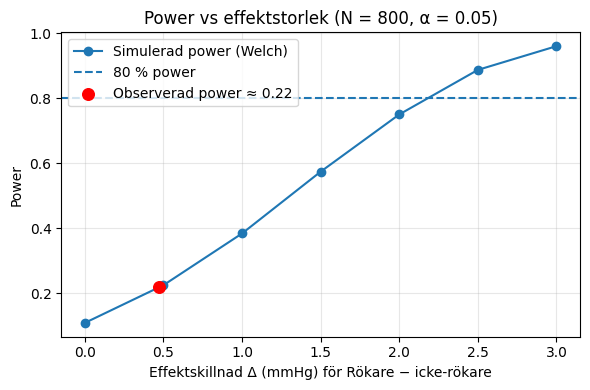

För att nå 80 % power med nuvarande stickprovsstorlek
krävs en sann effekt på ungefär Δ ≈ 2.18 mmHg.


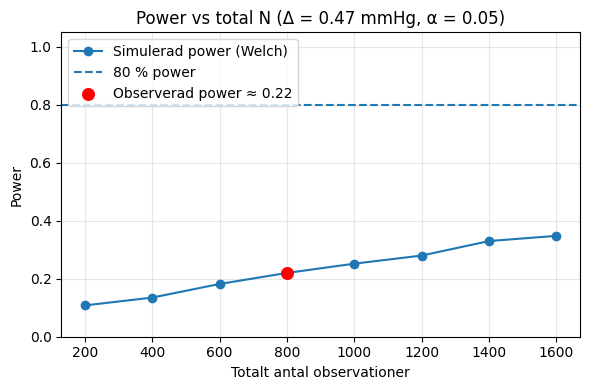

Power når inte 80 % inom intervallet N = 200–1600.

Beräknade värden för att nå 80 % power:
- Med nuvarande N krävs en effekt på ca Δ ≈ 2.54 mmHg
  (≈ 5.39 gånger större än observerad skillnad Δ_obs ≈ 0.47 mmHg)
- För att nå 80 % power vid Δ = 0.47 mmHg
  behövs totalt N ≈ 23,259 (≈ 6193 rökare och ≈ 17066 icke-rökare)
  vilket är ungefär 29.1 gånger fler än nu.


In [ ]:
from power_analysis import (
    simulate_power_welch,
    required_effect_for_power,
    required_n_for_power,
    power_curve_by_effect,
    power_curve_by_n,
    summarize_power_effects,
    summarize_power_sample_size
)
from power_plots import plot_power_vs_effect, plot_power_vs_n

smoker_yes = df.loc[df["smoker"] == "Yes", "systolic_bp"]
smoker_no  = df.loc[df["smoker"] == "No",  "systolic_bp"]

obs_diff = float(smoker_yes.mean() - smoker_no.mean())
real_total_n = len(smoker_yes) + len(smoker_no)

ALPHA = 0.05
TARGET_POWER = 0.80
TRIALS_EFFECT = 800
TRIALS_N = 800

# 1. Power vid observerad effekt
real_power = simulate_power_welch(
    smoker_yes,
    smoker_no,
    effect=obs_diff,
    n1=len(smoker_yes),
    n2=len(smoker_no),
    trials=TRIALS_EFFECT,
    alpha=ALPHA,
    one_sided=True,
)

print(f"Power för verkliga stickprovet (N = {real_total_n}, Δ_obs = {obs_diff:.2f}): {real_power:.3f}")


#Power vs effektstorlek
effects = np.arange(0.0, 3.1, 0.5)
effects, power_eff = power_curve_by_effect(
    smoker_yes,
    smoker_no,
    effects=effects,
    trials=TRIALS_EFFECT,
    alpha=ALPHA,
    one_sided=True,
)

plot_power_vs_effect(
    effects,
    power_eff,
    obs_diff=obs_diff,
    real_power=real_power,
    target_power=TARGET_POWER,
    alpha=ALPHA,
    total_n=real_total_n,
    group_label="Rökare − icke-rökare",
)

msg_d, delta_needed = summarize_power_effects(effects, power_eff, target_power=TARGET_POWER)
print(msg_d)



# Power vs stickprovsstorlek
total_ns = np.arange(200, 1601, 200)

total_ns, power_n, n1_list, n2_list = power_curve_by_n(
    smoker_yes,
    smoker_no,
    effect=obs_diff,
    total_ns=total_ns,
    trials=TRIALS_N,
    alpha=ALPHA,
    one_sided=True,
)

plot_power_vs_n(
    total_ns,
    power_n,
    real_total_n=real_total_n,
    real_power=real_power,
    target_power=TARGET_POWER,
    effect_chosen=obs_diff,
    alpha=ALPHA,
)

msg_N, N_needed = summarize_power_sample_size(total_ns, power_n, target_power=TARGET_POWER)
print(msg_N)


# Analytiska berökningar (80 % power)
delta_min = required_effect_for_power(
    smoker_yes,
    smoker_no,
    total_n=None,     # använd nuvarande N
    power=TARGET_POWER,
    alpha=ALPHA,
    one_sided=True,
)

prop_delta = delta_min / obs_diff

print("\nBeräknade värden för att nå 80 % power:")
print(f"- Med nuvarande N krävs en effekt på ca Δ ≈ {delta_min:.2f} mmHg")
print(f"  (≈ {prop_delta:.2f} gånger större än observerad skillnad Δ_obs ≈ {obs_diff:.2f} mmHg)")

N_req, n1_req, n2_req = required_n_for_power(
    smoker_yes,
    smoker_no,
    delta=obs_diff,
    power=TARGET_POWER,
    alpha=ALPHA,
    one_sided=True,
)

prop_N = N_req / real_total_n
print(f"- För att nå 80 % power vid Δ = {obs_diff:.2f} mmHg")
print(f"  behövs totalt N ≈ {N_req:,} (≈ {n1_req} rökare och ≈ {n2_req} icke-rökare)")
print(f"  vilket är ungefär {prop_N:.1f} gånger fler än nu.")


### Tolkning
Den observerade skillnaden i systoliskt blodtryck mellan rökare och icke-rökare var mycket liten (≈ 0,47 mmHg) och poweranalysen visar att den här studien har låg power (≈ 20 %). Det betyder att sannolikheten att upptäcka en så liten effekt med N = 800 är låg.

Både simuleringarna och de analytiska powerberäkningarna visar att:
-   en betydligt större sann effekt (≈ 2–2,5 mmHg) hade krävts för att nå 80 % power med nuvarande stickprovsstorlek, och
-   om den verkliga skillnaden faktiskt är 0,47 mmHg skulle ett mycket stort stickprov (≈ 23 000 individer totalt) behövas för att nå 80 % power.

Detta innebär att studien är underpowered, vilket gör att den icke-signifikanta skillnaden inte kan tolkas som stöd för att ingen verklig effekt finns. Resultaten bör därför tolkas försiktigt, och studien kan inte ge starka slutsatser om skillnader i blodtryck mellan rökare och icke-rökare.


## METODVAL
### Deskriptiv statistik och visualiseringar

Histogram, boxplots och sammanfattande mått (medelvärde, median, standardavvikelse) anbändes för att beskriva variablernas fördelning. Detta är standardmetoder för att identifiera centraltendens, spridning och möjliga extremvärden.

Källor: Pandas descriptive statistics och Matplotlib histogram/boxplot.


### Simulering kopplad till caset

 Ett 95 % konfidensintervall beräknades för andelen personer med sjukdom med normalapproximation, vilket är en vanlig metod när stickprovet är stort. För att kontrollera rimligheten i resultatet simulerade jag ett nytt stickprov med samma sannolika andel och jämförde den simulerade andelen med intervallet. Syftet var att se om variationen kan förklaras av slumpen.

Källor: NumPy-dokumentation; Agresti (2018), Statistical Methods for the Social Sciences.

### Konfidensintervall (normalapproximation, bootstrap och BCa)

För att skatta konfidensintervallet för medelvärdet av systoliskt blodtryck användes tre metoder:
-   Normalapproximation – lämplig vid stora stickprov då medelvärdet närmar sig normalfördelning enligt centrala gränsvärdessatsen.
-   Bootstrap percentil – en icke-parametrisk metod som inte kräver normalitet och baseras på resampling av datan.
-   Bootstrap BCa – en förbättrad bootstrapvariant som korrigerar för bias och skevhet och kan ge mer tillförlitliga intervall vid snedfördelade data.

Samtliga metoder gav nästan identiska konfidensintervall, vilket visar att skattningen är robust. Normalapproximationen bedöms därför fungera väl i detta fall, samtidigt som bootstrapmetoderna ger en viktig kontroll utan parameterrisker.

Källor
-   Wasserman, L. (2004). All of Statistics. Springer.
-   Efron, B., & Tibshirani, R. J. (1993). An Introduction to the Bootstrap. Chapman & Hall/CRC.

### Hypotesprövning
För att testa om rökare har högre systoliskt blodtryck än icke-rökare användes två metoder:
1. Welch’s t-test
Welch-testet valdes eftersom grupperna har olika storlek och kan ha olika varians, vilket gör det mer robust än det klassiska t-testet vid heterogen spridning. Testet kräver inte antagandet om lika varians och anses vara standard vid jämförelse av två oberoende grupper med okända och olika variansparametrar (Welch, 1947).

2. Bootstrap-test av medelskillnaden
Som komplement användes ett icke-parametriskt bootstrap-test baserat på resampling av gruppernas data. Metoden kräver inte normalfördelning och ger en direkt empirisk uppskattning av p-värde och konfidensintervall (Efron & Tibshirani, 1993).

Kombinationen av Welch’s t-test och bootstrap ger en robust prövning av hypotesen och möjliggör kontroll av resultaten även om normalantagandet inte skulle hålla.

Källor
-   Welch, B. L. (1947). The generalization of “Student’s” problem…
-   Efron, B., & Tibshirani, R. J. (1993). An Introduction to the Bootstrap.

### Poweranalys
För att bedöma studiens statistiska styrka genomfördes både simulerad och analytisk poweranalys:
-   Simulerad power för det faktiska stickprovet:
Power uppskattades med resampling baserat på de observerade blodtrycksvärdena för rökare och icke-rökare. I varje simulering drogs nya urval inom respektive grupp, en effektskillnad Δ lades till gruppen rökare och ett Welch’s t-test (ensidigt, α = 0,05) beräknades. Andelen simuleringar med p < 0,05 användes som skattning av power för det faktiska N (= 800) och den observerade effekten (Δ ≈ 0,47 mmHg). Denna typ av resampling-baserad poweranalys rekommenderas när man vill bevara den verkliga datans spridning och obalans mellan grupper.
-   Simulerad power som funktion av effektstorlek och stickprovsstorlek:
Samma metod användes för att simulera power vid olika effektskillnader (Δ) med nuvarande N, samt vid olika totala stickprovsstorlekar med bibehållen gruppfördelning. Detta gav en bild av hur power förändras om effekten vore större eller studien vore större.

-   Analytiska beräkningar (normalapproximation):
Med antagande om normalfördelning användes standardformler för skillnad i två medelvärden för att beräkna ungefär
    (i) hur stor effekt som skulle krävas för 80 % power givet nuvarande N, samt
    (ii) hur stort N som skulle krävas för 80 % power givet den observerade effekten.

Dessa beräkningar fungerar som ett teoretiskt komplement till simuleringen.

Källor: 
-   Good, P. (2006). Resampling Methods: A Practical Guide to Data Analysis.
-   Wasserman, L. (2004). All of Statistics.
-   Efron, B., & Tibshirani, R. (1993). An Introduction to the Bootstrap.
